# OCR
## API経由でのOCRによる文字起こし

ここではGCPが提供しているGoogle Cloud Vision APIを利用します。初期設定に関しては公式ドキュメントを参照ください。

[クイックスタート: Vision API を設定する  \|  Google Cloud](https://cloud.google.com/vision/docs/setup)

In [1]:
import io
import os

from google.cloud import vision

In [2]:
client = vision.ImageAnnotatorClient()

In [3]:
image_path = "../data/receipt01.png"
with io.open(image_path, 'rb') as image_file:
    content = image_file.read()

In [4]:
image = vision.Image(content=content)

In [5]:
response =  client.document_text_detection(
        image=image,
        image_context={'language_hints': ['ja']}
    )

## OCRによる文字起こし結果を確認

In [6]:
print(response.full_text_annotation.text)

PyCon JP Store
東京都千代田区神田美土代町7
2021年 10月15日(金) 16:00
領 収 証
証
チケット
1 1 ¥2,000
Tシャツ
1 1 ¥3,500
ステッカー
3
¥600
合計
現 金
お釣り
¥6, 100
¥10,000
¥3, 900



In [7]:
response.full_text_annotation.text

'PyCon JP Store\n東京都千代田区神田美土代町7\n2021年 10月15日(金) 16:00\n領 収 証\n証\nチケット\n1 1 ¥2,000\nTシャツ\n1 1 ¥3,500\nステッカー\n3\n¥600\n合計\n現 金\nお釣り\n¥6, 100\n¥10,000\n¥3, 900\n'

## 読み取った文字の座標情報

In [8]:
for page in response.full_text_annotation.pages:
    for block in page.blocks:
        for paragraph in block.paragraphs:
            for word in paragraph.words:
                for symbol in word.symbols:
                    pass

In [9]:
first_symbol =  response.full_text_annotation.pages[0].blocks[0].paragraphs[0].words[0].symbols[0]

In [10]:
symbol

property {
  detected_break {
    type_: LINE_BREAK
  }
}
bounding_box {
  vertices {
    x: 347
    y: 360
  }
  vertices {
    x: 356
    y: 360
  }
  vertices {
    x: 357
    y: 382
  }
  vertices {
    x: 348
    y: 382
  }
}
text: "0"
confidence: 0.9800000190734863

## (Cloud Vision APIの結果を扱う安くするためのVisionOCRクラスの設定)

In [11]:
import sys
sys.path.append("../util")
from vision_ocr import VisionOCR

In [12]:
ocr = VisionOCR(response, image=image_path)

In [13]:
ocr

## VisionAPI特有のOCRの機能

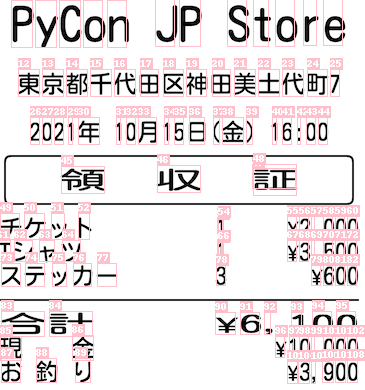

In [14]:
ocr.draw_hint(feature_type="symbol", file_name="", show_box_number=True)

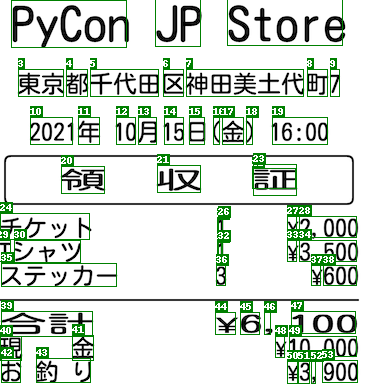

In [15]:
ocr.draw_hint(feature_type="word", file_name="", show_box_number=True)

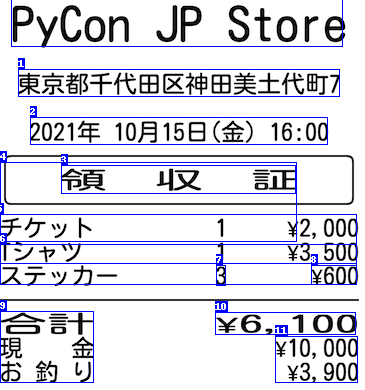

In [16]:
ocr.draw_hint(feature_type="paragraph", file_name="", show_box_number=True)

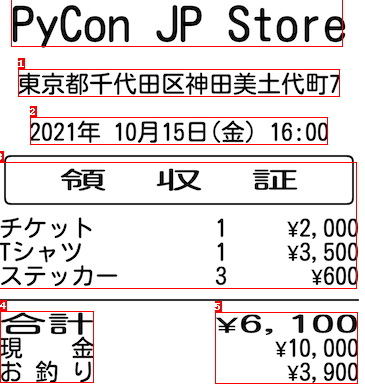

In [17]:
ocr.draw_hint(feature_type="block", file_name="", show_box_number=True)

# 情報抽出
## 正規表現による日付や商品名の抽出

In [18]:
import re

In [19]:
re.search(r"\d+月\d+日", response.full_text_annotation.text)

<re.Match object; span=(36, 42), match='10月15日'>

#### 辞書で検索

In [20]:
items = ["チケット", "Tシャツ", "パーカー",
               "ステッカー", "ネックストラップ"]

for item in items:
    if re.search(item, response.full_text_annotation.text):
        print(f"{item}は購入されました")

チケットは購入されました
Tシャツは購入されました
ステッカーは購入されました


## 固有表現抽出による日付や時間の抽出

In [21]:
import spacy
nlp = spacy.load('ja_ginza')

In [22]:
doc = nlp(response.full_text_annotation.text)
for ent in doc.ents:
    if ent.label_ in ("Date", "Time"):
        print(f"{ent.label_}: {ent.text}")

Date: 2021年 10月15日
Time: 16:00


## 文字列と座標情報を用いた合計金額の抽出

In [23]:
from PIL import Image
im = Image.open('../data/receipt01.png')
image_width = im.size[0]

In [24]:
total_count_word = [w for w in ocr.all_words 
                                      if w.text == "合計"][0]

In [25]:
total_count_word.bounding_box

BoundingBox(top_left=Vertex(x=1, y=311), top_right=Vertex(x=92, y=311), bottom_left=Vertex(x=1, y=336), bottom_right=Vertex(x=92, y=336))

In [26]:
image_width = im.size[0]
range_y_min = total_count_word.bounding_box.top_left.y 
range_y_max =  total_count_word.bounding_box.bottom_right.y

im.crop(
    (0,
     range_y_min, 
     image_width,
     range_y_max)
)

In [27]:
results = []
for symbol in ocr.all_symbols:
    # それぞれの文字の中心のx,y座標を求める
    x = (symbol.bounding_box.top_left.x + symbol.bounding_box.top_right.x) / 2
    y = (symbol.bounding_box. top_left.y + symbol.bounding_box.bottom_left.y) / 2
    if range_y_min <= y <=range_y_max:
        if total_count_word.bounding_box.top_right.x <= x:
            results.append(symbol)

In [28]:
"".join([s.text for s in results])

'¥6,100'